# Cross Subject Classification with Inception CNN

# Importing Packages

In [1]:
!pip install braindecode
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 13.2 MB/s eta 0:00:00


In [2]:
import braindecode
import mne

In [3]:
from scipy.io import loadmat
import scipy
import sklearn
import numpy as np
import pandas as pd
import glob
from mne.decoding import CSP
import os

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

In [5]:
import warnings
warnings.filterwarnings('ignore') # to ignore warnings

In [6]:
verbose = False                    # global variable to suppress output display of MNE functions
mne.set_log_level(verbose=verbose) # to suppress large info outputs

In [7]:
n_jobs = -1  # for multicore parallel processing, set it to 1 if cause memory issues, for full utilization set to -1

# Data Loading

## Kaggle

In [8]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
          pass

In [9]:
folder_path = "/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master"

## Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = "/content/drive/MyDrive/BCI/AI/Stroke_Notebooks/Data"

## Split 10 Subjects to 8 Training and 2 Testing


In [10]:
all_files   = glob.glob(folder_path + '/*T.mat')
len(all_files)     # if  return zero,then no file is loaded

10

In [11]:
all_files

['/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P03T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P01T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P02T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P08T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P04T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P09T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P10T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P06T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-In

In [12]:
def get_mne_epochs_complete(files_paths, verbose=verbose, t_start=2, fs=512, mode='train'):
    '''
    similar to get_mne_epochs, just appends data from all relevant files together to give a single
    epoch object
    '''
    eeg_data = []
    for filepath in files_paths:
        mat_data = loadmat(filepath)
        eeg_data.extend(mat_data['RawEEGData'])

    idx_start = fs*t_start      # fs*ts
    eeg_data = np.array(eeg_data)
    eeg_data = eeg_data[:, :, idx_start:]
    event_id = {'left-hand': 0, 'right-hand': 1} # pytorch expects labels in [0, n_classes-1]
    channel_names = ['F3', 'FC3', 'C3', 'CP3', 'P3', 'FCz', 'CPz', 'F4', 'FC4', 'C4', 'CP4', 'P4']
    info = mne.create_info(ch_names=channel_names, sfreq=fs, ch_types='eeg')
    epochs = mne.EpochsArray(eeg_data, info, verbose=verbose, tmin=t_start-3.0)
    epochs.set_montage('standard_1020')
    epochs.filter(1., None) # required be ICA, (7-30 Hz) later
    epochs.apply_baseline(baseline=(-.250, 0)) # linear baseline correction

    if mode == 'train': # this in only applicable for training data
        labels = []
        for filepath in files_paths:
            mat_data = loadmat(filepath)
            labels.extend(mat_data['Labels'].ravel() - 1)
        epochs.event_id = event_id
        epochs.events[:,2] = labels
    return epochs

In [13]:
train_subjects = all_files[0:8]
print(len(train_subjects))
test_subjects = all_files[8:]
print(len(test_subjects))

8
2


In [14]:
train_subjects

['/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P03T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P01T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P02T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P08T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P04T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P09T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P10T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P06T.mat']

In [15]:
test_subjects

['/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P07T.mat',
 '/kaggle/input/thumbmovement/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow-master/parsed_P05T.mat']

# Data Processing
Data Loading with Epochs & Band Pass Filtering & cutting  [0.5, 4.5] sec and 2sec window with 1 sec stride

## Epoch conversion

In [16]:
# loading data and filtering from 7 to 32 HZ
train_epochs_all = get_mne_epochs_complete(train_subjects).filter(7,32) # for all training subjects
test_epochs_all = get_mne_epochs_complete(test_subjects).filter(7,32) # for all training subjects

In [17]:
train_epochs_all.get_data().shape

(640, 12, 3072)

In [18]:
train_epochs_all

Number of events,640
Events,left-hand: 320right-hand: 320
Time range,-1.000 – 4.998 s
Baseline,-0.250 – 0.000 s


In [19]:
# Croping Data from 0.5 to 4.5 (4 seconds * 512)
train_epochs_all = train_epochs_all.crop(tmin=0.5, tmax=4.5, include_tmax=False)
test_epochs_all = test_epochs_all.crop(tmin=0.5, tmax=4.5, include_tmax=False)

In [20]:
train_epochs_all.get_data().shape

(640, 12, 2048)

In [21]:
train_epochs_all

Number of events,640
Events,left-hand: 320right-hand: 320
Time range,0.500 – 4.498 s
Baseline,-0.250 – 0.000 s


In [22]:
test_epochs_all

Number of events,160
Events,left-hand: 80right-hand: 80
Time range,0.500 – 4.498 s
Baseline,-0.250 – 0.000 s


In [23]:
# train_subjects_epochs = train_epochs_all.copy()
# test_subjects_epochs = test_epochs_all.copy()
# train_subjects_data, train_subjects_labels = train_subjects_epochs.get_data(), train_subjects_epochs.events[:,-1]
# test_subjects_data, test_subjects_labels = test_subjects_epochs.get_data(), test_subjects_epochs.events[:,-1]
# print('Shape of EEG Train Subjects Data: ', train_subjects_data.shape, '\t Shape of Labels: ', train_subjects_labels.shape)
# print('Shape of EEG Test Subjects Data: ', test_subjects_data.shape, '\t Shape of Labels: ', test_subjects_labels.shape)

## Windows Dataset Conversion
Type : [BaseConcatDataset](https://braindecode.org/stable/generated/braindecode.datasets.BaseConcatDataset.html#braindecode.datasets.BaseConcatDataset)

Taking window size of 2 seconds with stride 1 second

In [24]:
from braindecode.datautil import create_from_mne_epochs

# convert epochs to braindecode compatible datastructure
# 2sec windows with 0.125 sec stride
window_size = 1024 #1024 #1024 #50 # 3072
window_stride = 512 #768 #512 #256 # 50

In [25]:
train_windows_datasets = create_from_mne_epochs(
            [train_epochs_all], # expects list of epochs
            window_size_samples = window_size, window_stride_samples = window_stride,
            drop_last_window = False )

test_windows_datasets = create_from_mne_epochs(
            [test_epochs_all], # expects list of epochs
            window_size_samples = window_size, window_stride_samples = window_stride,
            drop_last_window = False )

In [26]:
def get_windows_datasets_labels(windows_dataset):
    labels = []
    for i in range(len(windows_dataset.datasets)):
        labels.extend(windows_dataset.datasets[i].y)
    return np.array(labels)

In [27]:
train_subjects_labels= get_windows_datasets_labels(train_windows_datasets)
test_subjects_labels= get_windows_datasets_labels(test_windows_datasets)

In [28]:
print(train_subjects_labels)
print(len(test_subjects_labels))

[0 0 0 ... 0 0 0]
480


In [29]:
print("Total Windows in a train Dataset: ", len(train_subjects_labels))
print("Total Windows in a test Dataset: ", len(test_subjects_labels))

Total Windows in a train Dataset:  1920
Total Windows in a test Dataset:  480


In [30]:
# train_windows_description

In [31]:
# train_windows_datasets.set_description = train_windows_description

In [32]:
# train_windows_datasets.set_description.labels[500:]

In [33]:
# print("Total Windows in a whole Dataset: ", len(train_windows_description))

## Preprocessing

In [34]:
from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor,
)

In [35]:
low_cut_hz = 8.  # low cut frequency for filtering
high_cut_hz = 32.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

In [36]:
# def custom_exp_moving_std_fn(epochs, factor_new=factor_new, init_block_size=init_block_size):
#     data = epochs.get_data()
#     for i in range(len(data)):
#         epochs._data[i] = exponential_moving_standardize(data[i],
#                         factor_new=factor_new, init_block_size=init_block_size)
#     return epochs

In [37]:
preprocessors = [
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(
        lambda data, factor: np.multiply(data, factor),  # Convert from V to uV
        factor=1e6,
    ),
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    # Preprocessor(
    #     # fn=custom_exp_moving_std_fn,  # Exponential moving standardization
    #     factor_new=factor_new,
    #     init_block_size=init_block_size,
    # ),
]

In [40]:
# preprocess(windows_datasets, preprocessors)
train_windows_datasets = preprocess(train_windows_datasets, preprocessors, n_jobs=-1)
test_windows_datasets = preprocess(test_windows_datasets, preprocessors, n_jobs=-1)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
Setting up band-pass filter from 8 - 32 Hz
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00

FIR filter parameters
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
---------------------
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB c

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
Using data from preloaded Raw for 3 events and 1024 original time points ...
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper pass

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
Setting up band-pass filter from 8 - 32 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)

FIR filter parameters
- Filter length: 845 samples (1.650 s)
---------------------

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Setting up band-pass filter from 8 - 32 Hz

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

- Filter length: 845 samples (1.650 s)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Setting up band-pass filter from 8 - 32 Hz
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
NOTE: pick_types() is a l

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from prelo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
Setting up band-pass filter from 8 - 32 Hz
- Upper passband edge: 32.00 Hz

- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
FIR filter parame

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
Using data from preloaded Raw for 3 events and 1024 original time points ...
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Using data from prelo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 3 events and 1024 original time points ...
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
- Filter length: 845 samples (1.650 s)

NOTE: pick_types() is

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [41]:
# 

## Convertion from window Dataset to 3D Numpy Array

### Window Dataset Exploration

In [42]:
print(len(train_windows_datasets[0]))
train_windows_datasets[0]

3


(array([[ -3737138.8,  -4194040. ,  -4590864.5, ...,  -6096567. ,
          -9761566. , -11539384. ],
        [-13387263. , -14927196. , -16638212. , ..., -13570341. ,
         -19523940. , -22464038. ],
        [ -6838889. ,  -7193023.5,  -7698213.5, ...,  -9669688. ,
         -14026863. , -16089753. ],
        ...,
        [-28724504. , -29541100. , -30289724. , ..., -11976313. ,
         -23255216. , -30121144. ],
        [-27087340. , -28237058. , -29314464. , ..., -13012696. ,
         -23495540. , -29743818. ],
        [-14500782. , -15028029. , -15536692. , ..., -10855175. ,
         -17199198. , -20614580. ]], dtype=float32),
 0,
 [0, 0, 1024])

In [43]:
print(len(train_windows_datasets[0][0]))
print(train_windows_datasets[0][0].shape)
#12 Channel * 1024 Sample (2 Seconds * 512)
# train_windows_datasets[0][0]

12
(12, 1024)


In [44]:
type(train_windows_datasets[1][0])

numpy.ndarray

In [45]:
print(len(train_windows_datasets[0][0][0]))
print(train_windows_datasets[0][0][0].shape)
train_windows_datasets[0][0][0]

1024
(1024,)


array([ -3737138.8,  -4194040. ,  -4590864.5, ...,  -6096567. ,
        -9761566. , -11539384. ], dtype=float32)

In [46]:
print(len(train_windows_datasets))
print(len(test_windows_datasets))
#1920 Window

1920
480


In [47]:
type(train_windows_datasets)

braindecode.datasets.base.BaseConcatDataset

In [48]:
# len(windows_datasets.set_description[0])

### Conversion from window to list

In [49]:
# if 408 % 240 > 168:
#   print("YES")

In [50]:
train_windows_subjects_list = []
for window in train_windows_datasets:
  train_windows_subjects_list.append(window[0])
print(len(train_windows_subjects_list))


1920


In [51]:
test_windows_subjects_list = []
for window in test_windows_datasets:
  test_windows_subjects_list.append(window[0])
print(len(test_windows_subjects_list))

480


In [52]:
# train = []
# test = []
# train_labels = []
# test_labels = []
# for idx,window in enumerate(train_windows_list):
#     if idx % 240 <168 :
#         train.append(windows_datasets[idx][0])
#         train_labels.append(windows_datasets.set_description.labels[idx])
#     else:
#         test.append(windows_datasets[idx][0])
#         test_labels.append(windows_datasets.set_description.labels[idx])

In [53]:
type(train_windows_subjects_list)

list

In [54]:
print(len(train_windows_subjects_list))
train_windows_subjects_list[12]

1920


array([[  2761610.5 ,   2164886.2 ,   1371408.1 , ...,   1190288.1 ,
          1657234.2 ,   1993007.2 ],
       [  2163526.8 ,   1463945.  ,    637377.4 , ...,    864616.2 ,
          1558263.  ,   2133130.8 ],
       [  2817508.2 ,   2574216.8 ,   2263019.8 , ...,   -339295.47,
           540671.9 ,   1304033.6 ],
       ...,
       [-15705238.  , -16072980.  , -15803208.  , ..., -14163393.  ,
        -14959701.  , -15342695.  ],
       [-12276058.  , -12459808.  , -12117240.  , ..., -11308647.  ,
        -11911580.  , -12246158.  ],
       [  5069181.5 ,   4633954.  ,   3745972.8 , ...,  -2314446.8 ,
          -911964.56,    305686.06]], dtype=float32)

### Conversion from list to numpy array

In [55]:
train_windows_subjects_array = np.array(train_windows_subjects_list)
train_windows_subjects_labels_array = np.array(train_subjects_labels)
test_windows_subjects_array = np.array(test_windows_subjects_list)
test_windows_subjects_labels_array = np.array(test_subjects_labels)

In [56]:
print(train_windows_subjects_array.shape)
print(train_windows_subjects_labels_array.shape)

(1920, 12, 1024)
(1920,)


In [57]:
print(test_windows_subjects_array.shape)
print(test_windows_subjects_labels_array.shape)

(480, 12, 1024)
(480,)


In [58]:
# data_array=np.vstack(data_list)
# label_array=np.hstack(label_list)
# group_array=np.hstack(groups_list)

In [59]:
# data_array=np.moveaxis(train_array,1,2)
# data_array.shape

In [60]:
group_list = []
for subject in np.linspace(1,8,8):
    group_list.extend([subject for _ in range(len(train_windows_subjects_array)//8)]) #since total 8 subjects
groups = np.array(group_list)

In [61]:
print(len(train_windows_subjects_array)//8)
print(len(group_list))

240
1920


In [62]:
# n_chans = train_windows_datasets[0][0].shape[0]
# input_window_samples = train_windows_datasets[0][0].shape[1]
# print(n_chans)
# print(input_window_samples)

In [63]:
n_chans = train_windows_subjects_array[0].shape[0]
input_window_samples = train_windows_subjects_array[0].shape[1]
print(n_chans)
print(input_window_samples)

12
1024


In [64]:
# train_windows_subjects_array

# Deep Learning with Braindecode

## Model Configuration

In [65]:
# Creating a model
import torch
from braindecode.util import set_random_seeds
# from braindecode.models import ShallowFBCSPNet, EEGNetv4
from braindecode.models import EEGInceptionMI

In [66]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)
cuda

True

In [67]:
n_chans = train_windows_subjects_array[0].shape[0]
input_window_samples = train_windows_subjects_array[0].shape[1]
n_classes = 2
print(n_chans)
print(input_window_samples)

12
1024


In [68]:
# model = EEGNetv4(
#     n_chans,
#     n_classes,
#     input_window_samples = window_size, #input_window_samples,
#     final_conv_length='auto',
# )
model = EEGInceptionMI(
    12,
    2,
    input_window_seconds = 2,
    sfreq  = 512
)

# Send model to GPU
if cuda:
    model.cuda()

In [69]:
# Training time
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier

In [70]:
import skorch

In [71]:
len(train_windows_subjects_array)

1920

In [72]:
lr =  0.01 #0.02
weight_decay = 0.5 * 0.001
batch_size = 128 #32
n_epochs = 10 #50 #25 #20 #use few epochs for quick verification

In [75]:
clf =  EEGClassifier(
                    model,
                    criterion=torch.nn.NLLLoss,
                    optimizer=torch.optim.AdamW,
                    train_split = None,
                    optimizer__lr=lr,
                    optimizer__weight_decay=weight_decay,
                    batch_size=batch_size,
                    callbacks=[
                        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
                    ],
                    device=device,
                    classes=2,
                    )

In [ ]:
test_acc = clf.score(test_array, y=test_labels_array)
print(f"Test acc: {(test_acc * 100):.2f}%")

Test acc: 69.10%


## Data Splitting

### Train Test split based on groups

In [ ]:
import numpy as np

In [ ]:
type(group_list)

list

In [73]:
group_list = []
for subject in np.linspace(1,8,8):
    group_list.extend([subject for _ in range(len(train_windows_subjects_array)//8)]) #since total 8 subjects
groups = np.array(group_list)

In [74]:
X = train_windows_subjects_array  # Features
y = train_windows_subjects_labels_array # Target variable
groups = np.array(group_list) # Group identifiers

# Shuffle

In [75]:
print(X.shape)
print(type(X))

(1920, 12, 1024)
<class 'numpy.ndarray'>


In [76]:
print(y.shape)
print(type(y))

(1920,)
<class 'numpy.ndarray'>


In [77]:
X_copy = X
y_copy = y

In [78]:
import numpy as np

# Assuming your data array is named 'data' and labels array is named 'labels'
num_trials, num_channels, num_samples = 1920, 12, 1024

# Shuffle the data and labels together
indices = np.arange(num_trials)
np.random.shuffle(indices)

shuffled_data = X_copy[indices]
shuffled_labels = y_copy[indices]

In [79]:
y_copy

array([0, 0, 0, ..., 0, 0, 0])

In [101]:
# shuffled_labels

In [100]:
# shuffled_data

In [99]:
# X_copy

In [97]:
# labels

In [96]:
# shuffled_data

In [98]:
# data

### Train Test split based on groups

In [113]:
# Proportion of data to allocate to the train set
train_proportion = 0.8

# Initialize lists to store train and test indices
train_indices = []
test_indices = []

In [103]:
# Get unique group identifiers
unique_groups = np.unique(groups)
unique_groups

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [112]:
# Iterate over each group
for group_id in unique_groups:
    # Get indices corresponding to the current group
    group_indices = np.where(groups == group_id)[0]

    # Shuffle the indices
    np.random.shuffle(group_indices)

    # Calculate the number of samples for training and testing
    num_samples = len(group_indices)
    num_train_samples = int(train_proportion * num_samples)

    # Split the indices into train and test
    train_indices.extend(group_indices[:num_train_samples])
    test_indices.extend(group_indices[num_train_samples:])

AttributeError: 'numpy.ndarray' object has no attribute 'extend'

In [110]:
# Convert indices to arrays
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

# Split the data
X_train, y_train, groups_train = X[train_indices], y[train_indices], groups[train_indices]
X_test, y_test, groups_test = X[test_indices], y[test_indices], groups[test_indices]

# Check the distribution of groups in train and test sets
train_group_distribution = np.bincount(groups_train.astype(int))
test_group_distribution = np.bincount(groups_test.astype(int))

print("Train Group Distribution:", train_group_distribution)
print("Test Group Distribution:", test_group_distribution)


IndexError: arrays used as indices must be of integer (or boolean) type

In [111]:
# Convert indices to arrays
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

# Split the data
X_train, y_train, groups_train = shuffled_data[train_indices], shuffled_labels[train_indices], groups[train_indices]
X_test, y_test, groups_test = shuffled_data[test_indices], shuffled_labels[test_indices], groups[test_indices]

# Check the distribution of groups in train and test sets
train_group_distribution = np.bincount(groups_train.astype(int))
test_group_distribution = np.bincount(groups_test.astype(int))

print("Train Group Distribution:", train_group_distribution)
print("Test Group Distribution:", test_group_distribution)

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
# X_train
# y_train
# X_test
# y_test

In [109]:
print(len(X_train))
print(len(X_test))

NameError: name 'X_train' is not defined

### Train Validation Test split based on groups

In [49]:
len(X)

1280

In [80]:
# Define the proportions for train, validation, and test sets
train_proportion = 0.6
validation_proportion = 0.2
test_proportion = 0.2

# Initialize lists to store train, validation, and test indices
train_indices = []
validation_indices = []
test_indices = []

# Get unique group identifiers
unique_groups = np.unique(groups)

In [81]:
# Iterate over each group
for group_id in unique_groups:
    # Get indices corresponding to the current group
    group_indices = np.where(groups == group_id)[0]

    # Shuffle the indices
    np.random.shuffle(group_indices)

    # Calculate the number of samples for training, validation, and testing
    num_samples = len(group_indices)
    num_train_samples = int(train_proportion * num_samples)
    num_validation_samples = int(validation_proportion * num_samples)
    num_test_samples = num_samples - num_train_samples - num_validation_samples

    # Split the indices into train, validation, and test
    train_indices.extend(group_indices[:num_train_samples])
    validation_indices.extend(group_indices[num_train_samples:num_train_samples + num_validation_samples])
    test_indices.extend(group_indices[num_train_samples + num_validation_samples:])

In [82]:
# Convert indices to arrays
train_indices = np.array(train_indices)
validation_indices = np.array(validation_indices)
test_indices = np.array(test_indices)

# Split the data
X_train, y_train, groups_train = X[train_indices], y[train_indices], groups[train_indices]
X_validation, y_validation, groups_validation = X[validation_indices], y[validation_indices], groups[validation_indices]
X_test, y_test, groups_test = X[test_indices], y[test_indices], groups[test_indices]

# Check the distribution of groups in train, validation, and test sets
train_group_distribution = np.bincount(groups_train.astype(int))
validation_group_distribution = np.bincount(groups_validation.astype(int))
test_group_distribution = np.bincount(groups_test.astype(int))

print("Train Group Distribution:", train_group_distribution)
print("Validation Group Distribution:", validation_group_distribution)
print("Test Group Distribution:", test_group_distribution)

Train Group Distribution: [  0 144 144 144 144 144 144 144 144]
Validation Group Distribution: [ 0 48 48 48 48 48 48 48 48]
Test Group Distribution: [ 0 48 48 48 48 48 48 48 48]


In [83]:
# Convert indices to arrays
train_indices = np.array(train_indices)
validation_indices = np.array(validation_indices)
test_indices = np.array(test_indices)

# Split the data
X_train, y_train, groups_train = shuffled_data[train_indices], shuffled_labels[train_indices], groups[train_indices]
X_validation, y_validation, groups_validation = shuffled_data[validation_indices], shuffled_labels[validation_indices], groups[validation_indices]
X_test, y_test, groups_test = shuffled_data[test_indices], shuffled_labels[test_indices], groups[test_indices]

# Check the distribution of groups in train, validation, and test sets
train_group_distribution = np.bincount(groups_train.astype(int))
validation_group_distribution = np.bincount(groups_validation.astype(int))
test_group_distribution = np.bincount(groups_test.astype(int))

print("Train Group Distribution:", train_group_distribution)
print("Validation Group Distribution:", validation_group_distribution)
print("Test Group Distribution:", test_group_distribution)

Train Group Distribution: [  0 144 144 144 144 144 144 144 144]
Validation Group Distribution: [ 0 48 48 48 48 48 48 48 48]
Test Group Distribution: [ 0 48 48 48 48 48 48 48 48]


In [62]:
# X_train
# y_train
# X_test
# y_test
# X_validation
# y_validation

In [84]:
print(len(X_train))
print(len(X_test))
print(len(X_validation))

1152
384
384


### Predifined Model Training

In [86]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split, SliceDataset

In [87]:
from skorch.dataset import Dataset

In [88]:
val_dataset = Dataset(X_validation, y_validation)

In [89]:
# lr = 0.00625 
lr = 0.001
weight_decay = 0
batch_size = 288
n_epochs = 150

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(val_dataset),
    # train_split= predefined_split,
    # train_split= None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=n_classes,
    max_epochs=n_epochs,
)

In [90]:
hist = clf.fit(X_train, y=y_train)
in_test_acc = clf.score(X_test, y=y_test)
print(f"In Test acc: {(in_test_acc * 100):.2f}%")
out_test_acc = clf.score(test_windows_subjects_array, y=test_windows_subjects_labels_array)
print(f"Out Test acc: {(out_test_acc * 100):.2f}%")

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr       dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  --------
      1            0.5729        0.9237       0.5938            0.5938      136.2332  0.0010  180.3125
      2            0.6606        0.5957       0.6172            0.6172        7.9815  0.0010  66.4677
      3            0.5182        0.5260       0.4818            0.4818        2.5067  0.0010  66.5520
      4            0.5295        0.4884       0.4896            0.4896        1.6250  0.0010  66.5686
      5            0.8047        0.4444       0.7135            0.7135        0.5506  0.0010  66.5746
      6            0.6163        0.3929       0.5729            0.5729        0.8790  0.0010  66.5717
      7            0.8299        0.3362       0.7500            0.7500        0.6226  0.0010  66.5640
      8            0.8003        0.2892       0.6771            0.6771        0

In [122]:
hist = clf.fit(X_train, y=y_train)

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr      dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  -------
      1            0.7500        0.6370       0.7031            0.7031        0.5623  0.0001  86.2425
      2            0.8385        0.4637       0.7839            0.7839        0.4394  0.0001  71.2195
      3            0.9062        0.3574       0.7865            0.7865        0.4737  0.0001  71.2194
      4            0.5755        0.2767       0.5781            0.5781        1.4752  0.0001  71.2277
      5            0.9132        0.2174       0.7656            0.7656        0.5867  0.0001  71.2019
      6            0.9523        0.1299       0.7839            0.7839        0.6420  0.0001  71.1938
      7            0.9844        0.0959       0.8568            0.8568        0.3497  0.0001  71.2097
      8            0.9948        0.0868       0.8854            0.8854        0.35

In [1]:
len(X_train)

NameError: name 'X_train' is not defined

In [68]:
# clf.history

In [123]:
test_acc = clf.score(X_test, y=y_test)
print(f"Test acc: {(test_acc * 100):.2f}%")

Test acc: 82.55%


In [124]:
test_acc = clf.score(test_windows_subjects_array, y=test_windows_subjects_labels_array)
print(f"Test acc: {(test_acc * 100):.2f}%")

Test acc: 57.92%


In [91]:
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
for i in range(clf.history[-1]["epoch"]):
    train_loss.append(clf.history[i]["train_loss"])
    valid_loss.append(clf.history[i]["valid_loss"])
    train_accuracy.append(clf.history[i]["train_accuracy"])
    valid_accuracy.append(clf.history[i]["valid_accuracy"])

In [92]:
import matplotlib.pyplot as plt

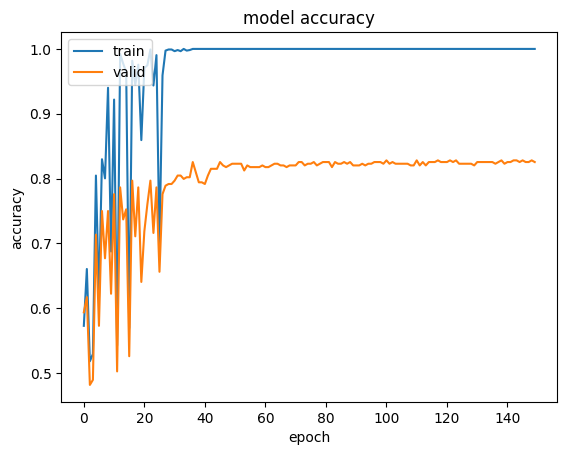

In [93]:
# summarize history for accuracy
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

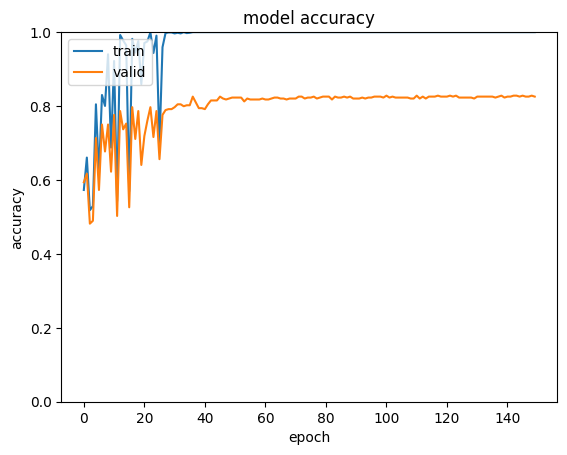

In [94]:
# summarize history for accuracy
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

In [95]:
# train_accuracy

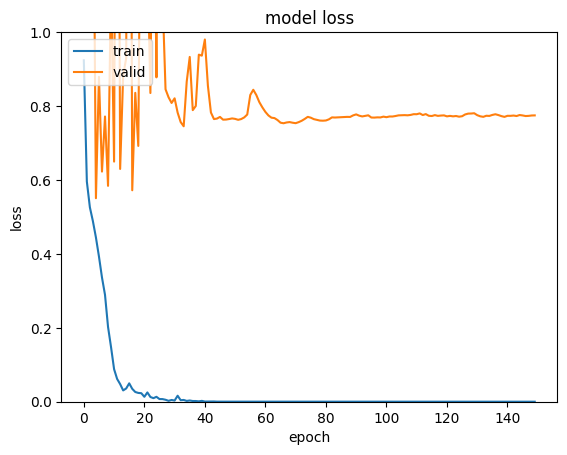

In [96]:
# summarize history for loss
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

plt.show()

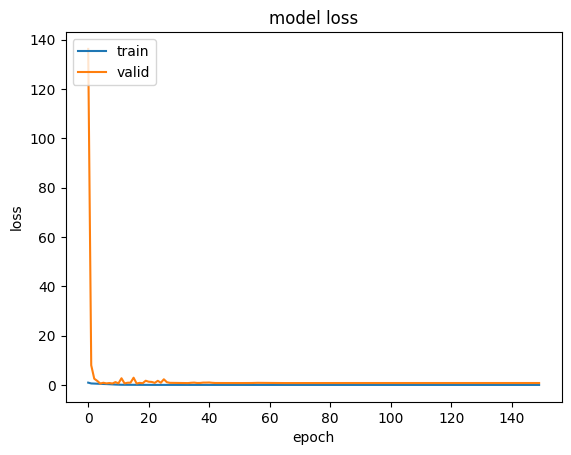

In [97]:
# summarize history for loss
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [98]:
# Import the necessary modules
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [99]:
# Get the predicted probabilities and labels from the classifier
y_pred_proba = clf.predict_proba(X_test)[:, 1] # get the probability of the positive class
y_pred = clf.predict(X_test) # get the predicted labels

# Compute the ROC curve and the AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

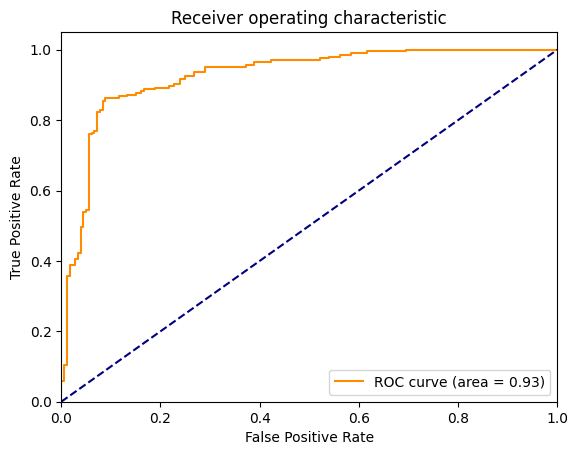

In [100]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [102]:
# Define class labels (replace with your class labels if needed)
class_names = ['Right', 'Left']

In [103]:
cm = confusion_matrix(y_test, y_pred)

Confusion matrix, without normalization


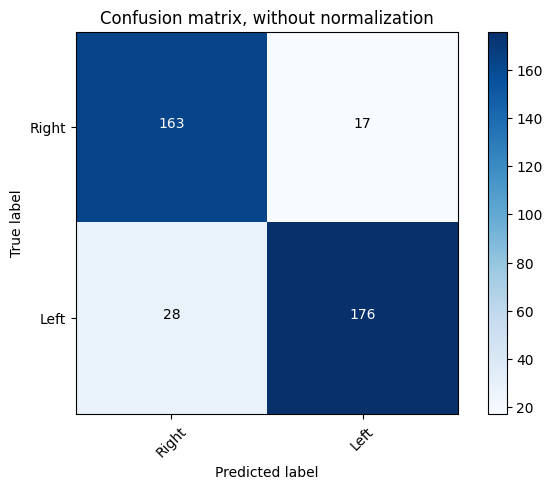

In [104]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix


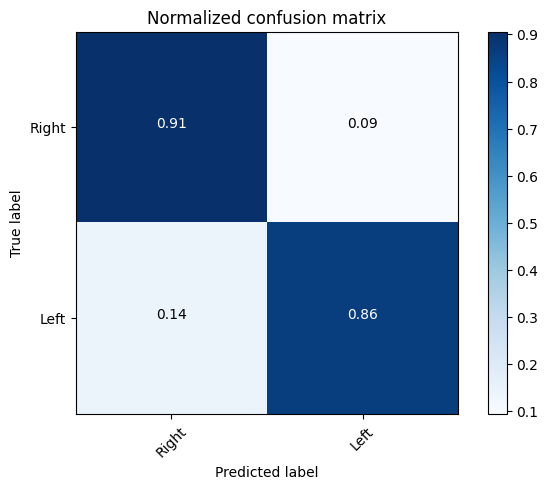

In [105]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

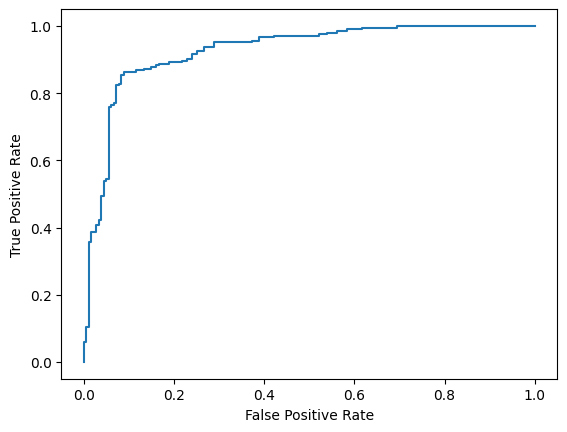

In [107]:
#define metrics
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [108]:
auc = np.trapz(tpr, fpr)
print(f"Model AUC score: {auc:.4f}")

Model AUC score: 0.9261


In [138]:
best_validation_acc = clf.callbacks_[4][1].best_score_ # a hack to get best validation accuracy

In [75]:
best_validation_acc

1.0

# Shallow CNN

In [62]:
from scipy.io import loadmat
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
import tensorflow as tf
from keras.constraints import MaxNorm
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D,BatchNormalization, Dropout, Conv2D, Dense, Flatten, Input, Activation,AveragePooling2D, MaxPooling2D
from tensorflow import keras
import os
import gc

2024-02-19 21:01:51.446653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 21:01:51.446777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 21:01:51.598261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [63]:
"""
FbC(NN)SP
Filterbank CSP implemented as a CNN architecture
Takes dictionary "params" as input:
    params['t_filter_n']: number of temporal filters to calculate
    params['t_filter_order']: order (kernel size-1) of the temporal filters
    params['s_filter_n']: number of spatial filters to calculate
    params['avg_samples']: number of timepoint samples to average oscillatory power

"""

def FBC_NN_SP(X: np.ndarray, params : dict, n_classes: int) -> keras.Model:
    
    ## Input and formatting ##
    n_channels = X.shape[1]

    input_shape = X.shape[1:]
    
    inputLayer = Input(input_shape)
    
    reshapeLayer = tf.expand_dims(inputLayer,axis=-1)  
    
    ## Temporal filtering ##
    conv2dLayer_1 = Conv2D(filters = params['t_filter_n'], 
                            kernel_size= (1,params['t_filter_order']+1), 
                            activation='linear',
                            use_bias = False,
                            padding = 'valid')(reshapeLayer) 
    
    ## Spatial filtering ##
    depthconvLayer = DepthwiseConv2D(kernel_size= (n_channels,1), 
                                     activation='linear',
                                     padding = 'valid',
                                     depth_multiplier=params['s_filter_n'],
                                     use_bias = False)(conv2dLayer_1) 
    
    
    ## Signal Power/Variance estimation ##
    activationLayer_1 = Activation(activation = tf.math.square)(depthconvLayer)
    poolLayer_1 = AveragePooling2D(pool_size=(1, conv2dLayer_1.shape[2]))(activationLayer_1) 
    
    ## Logistic/Softmax Regression ##
    flatFeatures = Flatten()(poolLayer_1)
    if n_classes == 2:
        outputLayer = Dense(units = 1,activation='sigmoid')(flatFeatures)
    else:
        outputLayer = Dense(units = n_classes,activation='softmax')(flatFeatures)        
    
    model = keras.Model(inputLayer,outputLayer)
    return model

In [64]:
"""
FbC(NN)SP
Filterbank CSP implemented as a CNN architecture
Takes dictionary "params" as input:
    params['t_filter_n']: number of temporal filters to calculate
    params['t_filter_order']: order (kernel size-1) of the temporal filters
    params['s_filter_n']: number of spatial filters to calculate
    params['avg_samples']: number of timepoint samples to average oscillatory power

"""

def FBC_NN_SP(X: np.ndarray, params : dict, n_classes: int) -> keras.Model:
    
    ## Input and formatting ##
    n_channels = X.shape[1]

    input_shape = X.shape[1:]
    
    inputLayer = Input(input_shape)
    
    reshapeLayer = tf.expand_dims(inputLayer,axis=-1)  
    
    ## Temporal filtering ##
    conv2dLayer_1 = Conv2D(filters = params['t_filter_n'], 
                            kernel_size= (1,params['t_filter_order']+1), 
                            activation='linear',
                            use_bias = False,
                            padding = 'valid')(reshapeLayer) 
    
    ## Spatial filtering ##
    depthconvLayer = DepthwiseConv2D(kernel_size= (n_channels,1), 
                                     activation='linear',
                                     padding = 'valid',
                                     depth_multiplier=params['s_filter_n'],
                                     use_bias = False)(conv2dLayer_1) 
    
    
    ## Signal Power/Variance estimation ##
    activationLayer_1 = Activation(activation = tf.math.square)(depthconvLayer)
    poolLayer_1 = AveragePooling2D(pool_size=(1, conv2dLayer_1.shape[2]))(activationLayer_1) 
    
    ## Logistic/Softmax Regression ##
    flatFeatures = Flatten()(poolLayer_1)
    if n_classes == 2:
        outputLayer = Dense(units = 1,activation='sigmoid')(flatFeatures)
    else:
        outputLayer = Dense(units = n_classes,activation='softmax')(flatFeatures)        
    
    model = keras.Model(inputLayer,outputLayer)
    return model

In [65]:
# Filterbank C(NN)SP parameters
params = {
    "t_filter_n": 2,
    "t_filter_order":2,
    "s_filter_n" : 2
    }

# Define the model
fbcnnsp = FBC_NN_SP(X=X_test, params=params, n_classes=len(np.unique(y_test)))

# Print model
print(fbcnnsp.summary())   

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1024)]        0         
                                                                 
 tf.expand_dims (TFOpLambda  (None, 12, 1024, 1)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 12, 1022, 2)       6         
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 1022, 4)        48        
 eConv2D)                                                        
                                                                 
 activation (Activation)     (None, 1, 1022, 4)        0         
                                                                 
 average_pooling2d (Average  (None, 1, 1, 4)           0     

In [67]:
model = FBC_NN_SP(X=X_test, params=params, n_classes=2) # FBC(NN)SP

In [68]:
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate = 0.001),
                  metrics=["accuracy"])

In [69]:
hist = model.fit(X_test,y_test)

I0000 00:00:1708376963.429366     213 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.4805


### Validation Split (Manual Sklearn)

In [ ]:
# MLP with manual validation set
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [ ]:

# split into 80% for train and 20% for validation
X_train, X_test, y_train, y_test = train_test_split(X_train, Y, test_size=0.33, random_state=seed)
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=10)

In [ ]:
# train , test = cv.split(windows_datasets[],y=windows_datasets.set_description.labels, groups=groups)

In [ ]:
clf =  EEGClassifier(
                    model,
                    criterion=torch.nn.NLLLoss,
                    optimizer=torch.optim.AdamW,
                    # iterator_train = StratifiedShuffleSplit(),#cv.split(epochs, y=labels, groups=groups),
                    # train_split=predefined_split(train_set),  # using valid_set for validation
                    # train_split=predefined_split,  # using valid_set for validation
                    # train_split = cv.split(epochs, y=labels, groups=groups),
                    train_split = None,
#                     train_split = skorch.dataset.ValidSplit(cv=cv.split(windows_datasets,
#                           y=windows_datasets.set_description.labels, groups=groups)),

                    optimizer__lr=lr,
                    optimizer__weight_decay=weight_decay,
                    batch_size=batch_size,
                    callbacks=[
                        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
                    ],
                    device=device,
                    # classes=classes,

                    )

In [ ]:
clf.fit(train_windows_subjects_array, y=train_windows_subjects_labels_array, epochs=10)

In [ ]:
clf.fit

## Model Training

In [ ]:
def training_function(windows_datasets, n_epochs=25):
    print('\n', '#'*25, 'Cross Subject Training:', '#'*25, '\n')
    dataset = windows_datasets
    clf.fit(dataset, y=dataset.set_description.labels, epochs=n_epochs);
    best_validation_acc = clf.callbacks_[4][1].best_score_ # a hack to get best validation accuracy
    best_validation_kappa = (2*best_validation_acc)-1
    print("Best Cross Validation Kappa Score: {:.2f}".format(best_validation_kappa))

In [ ]:
# training_function(windows_datasets, n_epochs=n_epochs);